In [165]:
import pandas as pd 
from pandas import read_csv
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#Scikit-learn Models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report,confusion_matrix,average_precision_score  

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [66]:
filename = 'Telco-customer-churn.csv'
dataset = read_csv(filename)

In [67]:
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# BaseLine Accuracy

Base acuracy is 73%.

In [68]:
print(dataset.groupby(['Churn']).count())

print("Baseline Accuray: ", 5174/(5174+1869))

       customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
Churn                                                                   
No           5174    5174           5174     5174        5174    5174   
Yes          1869    1869           1869     1869        1869    1869   

       PhoneService  MultipleLines  InternetService  OnlineSecurity  \
Churn                                                                 
No             5174           5174             5174            5174   
Yes            1869           1869             1869            1869   

       OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
Churn                                                             
No             5174              5174         5174         5174   
Yes            1869              1869         1869         1869   

       StreamingMovies  Contract  PaperlessBilling  PaymentMethod  \
Churn                                                               
No             

# Assumptions:

- The sample data is correct represetation of the entire population and is randomly selected
- The columns in the dataset are exhaustive list of features that determine churn rate

In [69]:
dataset[["TotalCharges"]] = dataset[["TotalCharges"]].replace(" ", np.NaN)
dataset['TotalCharges'] = dataset['TotalCharges'].replace(np.NaN, 0).astype('float32')

In [70]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float32
Churn               7043 non-null object
dtypes: float32(1), float64(1), 

In [71]:
dataset.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.732178
std,0.368612,24.559481,30.090047,2266.794434
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.549988
50%,0.000000,29.000000,70.350000,1394.550049
75%,0.000000,55.000000,89.850000,3786.599976
max,1.000000,72.000000,118.750000,8684.799805


In [72]:
dataset.tenure.describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

Tenure can vary from 0 months to 72 months. This is how long customer is with Telco.

In [73]:
dataset[['MonthlyCharges','tenure','TotalCharges']].head()

,MonthlyCharges,tenure,TotalCharges
0,29.85,1,29.850000
1,56.95,34,1889.500000
2,53.85,2,108.150002
3,42.30,45,1840.750000
4,70.70,2,151.649994


Total Charges = Monthly Charges * Tenure. So, we can drop the TotalCharges from the model.

# Heat Map Analysis

- we found that additional services are strongly correlated so im replacing the No Internet services as No
- Still we see that streaming TV and Streaming movies are strongly correlated so lets combine them in to one
- Partners and Dependents are also highly (Negatively) correlated so lets combine them in to one - as FAMILY
- we also find that Phone services and Multilines are highly correlated so lets drop phone lines from our model

In [74]:
#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    dataset[i]  = dataset[i].replace({'No internet service' : 'No'})  

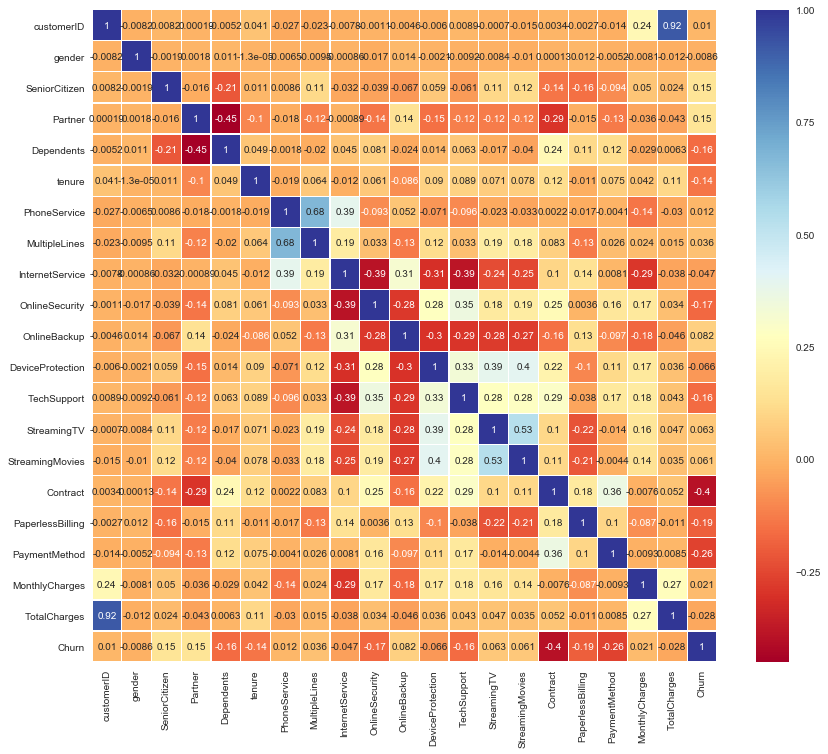

In [75]:
plt.figure(figsize=(14, 12))
corr = dataset.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="RdYlBu", annot = True)

In [76]:
list_family = []
for rows in range(len(dataset['Partner'])):
    if ((dataset['Partner'][rows] == 'No') and (dataset['Dependents'][rows] == 'No')):
        list_family.append('No')
    else:
        list_family.append('Yes')
dataset['Family'] = list_family

In [77]:
list_streaming_services = []
for rows_stv in range(len(dataset['StreamingTV'])):
    if ((dataset['StreamingTV'][rows_stv] == 'No') and (dataset['StreamingMovies'][rows_stv] == 'No')):
        list_streaming_services.append('No')
    else:
        list_streaming_services.append('Yes')
dataset['StreamingServices'] = list_streaming_services

In [78]:
list_online_services = []
for rows_os in range(len(dataset['OnlineSecurity'])):
    if ((dataset['OnlineSecurity'][rows_os] == 'No') and (dataset['OnlineBackup'][rows_os] == 'No')):
        list_online_services.append('No')
    else:
        list_online_services.append('Yes')
dataset['OnlineServices'] = list_online_services

In [79]:
from sklearn.preprocessing import LabelEncoder

def Encoder(a):
    le = LabelEncoder()
    x = le.fit_transform(a)
    return x

dataset[["Churn"]] = Encoder(dataset[["Churn"]])

Use cut when you need to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable.

In [82]:
dataset['TenureRange'] = pd.cut(dataset['tenure'], 5)
dataset[['TenureRange', 'Churn']].groupby(['TenureRange'], as_index=False).mean().sort_values(by='TenureRange', ascending=True)


dataset.loc[ dataset['tenure'] <= 8, 'TenureCat'] = 0
dataset.loc[(dataset['tenure'] > 8) & (dataset['tenure'] <= 15), 'TenureCat'] = 1
dataset.loc[(dataset['tenure'] > 15) & (dataset['tenure'] <= 30), 'TenureCat'] = 2
dataset.loc[(dataset['tenure'] > 30) & (dataset['tenure'] <= 45 ), 'TenureCat'] = 3
dataset.loc[(dataset['tenure'] > 45) & (dataset['tenure'] <= 60 ), 'TenureCat'] = 4
dataset.loc[ dataset['tenure'] > 60, 'TenureCat'] = 5

dataset[["TenureCat"]] = dataset[["TenureCat"]].astype(np.int64)

dataset[['tenure','TenureRange','TenureCat']].head()

,tenure,TenureRange,TenureCat
0,1,"(-0.072, 14.4]",0
1,34,"(28.8, 43.2]",3
2,2,"(-0.072, 14.4]",0
3,45,"(43.2, 57.6]",3
4,2,"(-0.072, 14.4]",0


In [83]:
dataset['MonthlyChargesRange'] = pd.cut(dataset['MonthlyCharges'], 5)
dataset[['MonthlyChargesRange', 'Churn']].groupby(['MonthlyChargesRange'], as_index=False).mean().sort_values(by='MonthlyChargesRange', ascending=True)


dataset.loc[ dataset['MonthlyCharges'] <= 20, 'MonthlyChargesCat'] = 0
dataset.loc[(dataset['MonthlyCharges'] > 20) & (dataset['MonthlyCharges'] <= 40), 'MonthlyChargesCat'] = 1
dataset.loc[(dataset['MonthlyCharges'] > 40) & (dataset['MonthlyCharges'] <= 60), 'MonthlyChargesCat'] = 2
dataset.loc[(dataset['MonthlyCharges'] > 60) & (dataset['MonthlyCharges'] <= 80 ), 'MonthlyChargesCat'] = 3
dataset.loc[(dataset['MonthlyCharges'] > 80) & (dataset['MonthlyCharges'] <= 100 ), 'MonthlyChargesCat'] = 4
dataset.loc[ dataset['MonthlyCharges'] > 100, 'MonthlyChargesCat'] = 5

dataset[["MonthlyChargesCat"]] = dataset[["MonthlyChargesCat"]].astype(np.int64)
dataset[['MonthlyCharges','MonthlyChargesRange','MonthlyChargesCat']].head(10)

,MonthlyCharges,MonthlyChargesRange,MonthlyChargesCat
0,29.85,"(18.15, 38.35]",1
1,56.95,"(38.35, 58.45]",2
2,53.85,"(38.35, 58.45]",2
3,42.30,"(38.35, 58.45]",2
4,70.70,"(58.45, 78.55]",3
5,99.65,"(98.65, 118.75]",4
6,89.10,"(78.55, 98.65]",4
7,29.75,"(18.15, 38.35]",1
8,104.80,"(98.65, 118.75]",5
9,56.15,"(38.35, 58.45]",2


In [84]:
columns_to_drop = ['tenure', 'TenureRange', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 
                   'StreamingTV', 'StreamingMovies', 'MonthlyChargesRange','MonthlyCharges','customerID',
                   'PhoneService','TotalCharges','gender']
dataset = dataset.drop(columns_to_drop, axis=1)

In [85]:
#dataset[["gender"]] = Encoder(dataset[["gender"]])
dataset[["MultipleLines"]] = Encoder(dataset[["MultipleLines"]])
dataset[["InternetService"]] = Encoder(dataset[["InternetService"]])
dataset[["Contract"]] = Encoder(dataset[["Contract"]])
dataset[["PaperlessBilling"]] = Encoder(dataset[["PaperlessBilling"]])
dataset[["PaymentMethod"]] = Encoder(dataset[["PaymentMethod"]])
dataset[["DeviceProtection"]] = Encoder(dataset[["DeviceProtection"]])
dataset[["TechSupport"]] = Encoder(dataset[["TechSupport"]])

dataset[["Family"]] = Encoder(dataset[["Family"]])
dataset[["StreamingServices"]] = Encoder(dataset[["StreamingServices"]])
dataset[["OnlineServices"]] = Encoder(dataset[["OnlineServices"]])

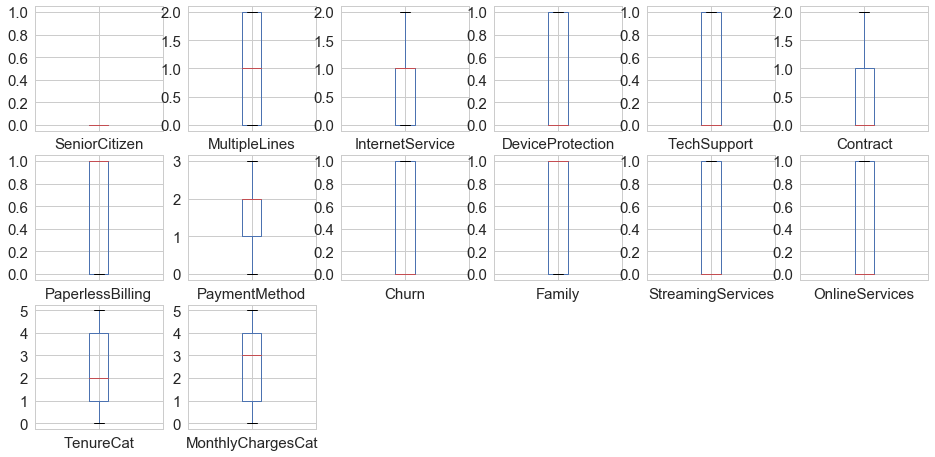

In [86]:
# box and whisker plots
dataset.plot(kind='box', subplots=True, layout=(6,6), fontsize=15, figsize=(16,16))
plt.show()

In [87]:
X = dataset.drop("Churn", axis=1)
y = dataset["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}
clf = RandomForestClassifier(**params).fit(X_train, y_train)

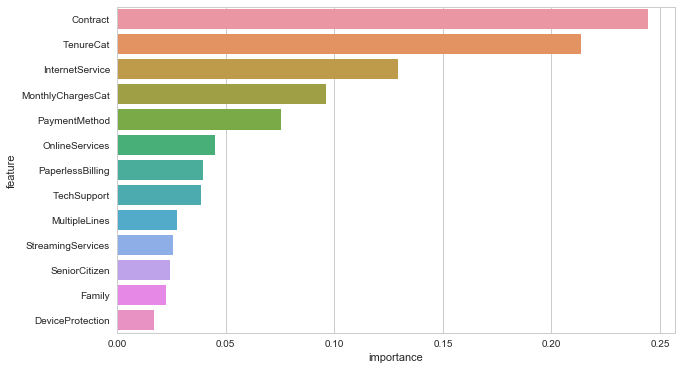

In [88]:
indices = np.argsort(clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(X_train.shape[1]):
  feature_rank.loc[f] = [f+1,
                         X_train.columns[indices[f]],
                         clf.feature_importances_[indices[f]]]

plt.figure(figsize=(10, 6))
sns.barplot( y = 'feature', x = 'importance', data = feature_rank )

# Model Bulding:

In [89]:
X = dataset.drop("Churn", axis=1)
Y = dataset["Churn"]

validation_size = 0.20
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

In [92]:
dataset.head()

,SeniorCitizen,MultipleLines,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Churn,Family,StreamingServices,OnlineServices,TenureCat,MonthlyChargesCat
0,0,1,0,0,0,0,1,2,0,1,0,1,0,1
1,0,0,0,1,0,1,0,3,0,0,0,1,3,2
2,0,0,0,0,0,0,1,3,1,0,0,1,0,2
3,0,1,0,1,1,1,0,0,0,0,0,1,3,2
4,0,0,1,0,0,0,1,2,1,0,0,0,0,3


In [93]:
num_folds = 10
seed = 7
scoring = 'accuracy'

# Base Model Building 

Logistic Regression, KNN classifier,  NaiveBayes Classifier, DecisionTree Classifier 

In [120]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)  
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)  
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) 
    print(msg)

LR: 0.790559 (0.018207)
KNN: 0.764284 (0.023359)
NB: 0.759484 (0.021455)
CART: 0.729502 (0.010897)


# Hyper Tuning the parameters

In [108]:
# KNN Algorithm tuning
k_values = np.array([1,3,5,7,9,11,13,15,17,19,21,23,25])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.787895 using {'n_neighbors': 21}


In [107]:
#Decision Tree Hyper Tuning
max_depth = np.array([1,3,5,7,9,11,13,15,17,19,21])
min_samples_leaf = np.array([3,5,7,9,11,13,15,17,19,21])
param_grid = dict(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
#param_grid = dict(max_depth=max_depth)
model = DecisionTreeClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.788072 using {'max_depth': 15, 'min_samples_leaf': 21}


In [172]:
#Logistic Regression
parameters = {'C':np.logspace(0, 4, 10), 
              'penalty' : ['l1', 'l2']}

model = LogisticRegression()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=parameters, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.791977 using {'C': 7.742636826811269, 'penalty': 'l1'}


# Training the base models after tuning

In [188]:
models = []
models.append(('LR', LogisticRegression(C = 7.742636826811269, penalty='l1')))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 21)))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier(max_depth = 15, min_samples_leaf = 21)))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.791980 (0.017703)
KNN: 0.787896 (0.017039)
NB: 0.759484 (0.021455)
CART: 0.787719 (0.016850)


# Ensemble Models

AdaBoost Classifier - Since it works best with classification problems

RandomForest Classifier

In [114]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('RF', RandomForestClassifier(**params)))

results = []
names = []
for name, model in ensembles: 
    kfold = KFold(n_splits=num_folds, random_state=seed) 
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.798015 (0.019893)
RF: 0.796951 (0.019816)


# Hyper Tuning the parameters

In [126]:
# Adaboost Classifier

learning_rate=np.array([0.05, 0.1, 0.25, 0.5, 0.75, 1])
n_estimators=np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
model = AdaBoostClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.800319 using {'learning_rate': 1.0, 'n_estimators': 30}


# Training the models after tuning

In [127]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier(learning_rate = 1.0, n_estimators = 30)))
ensembles.append(('RF', RandomForestClassifier(**params)))

results = []
names = []
for name, model in ensembles: 
    kfold = KFold(n_splits=num_folds, random_state=seed) 
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.800324 (0.020233)
RF: 0.796951 (0.019816)


# Validation of the trained model

In [189]:
models = []
models.append(('LR', LogisticRegression(C = 7.742636826811269, penalty='l1')))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 21)))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier(max_depth = 15, min_samples_leaf = 21)))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_validation, Y_validation, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.804777 (0.040093)
KNN: 0.796981 (0.045977)
NB: 0.764357 (0.034241)
CART: 0.797685 (0.044464)


In [128]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier(learning_rate = 1.0, n_estimators = 30)))
ensembles.append(('RF', RandomForestClassifier(**params)))

results = []
names = []
for name, model in ensembles: 
    kfold = KFold(n_splits=num_folds, random_state=seed) 
    cv_results = cross_val_score(model, X_validation, Y_validation, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.806211 (0.035983)
RF: 0.809048 (0.040019)


# Model Comparison Before Finalizing

Among the above models we could see that the Logistic Regression and AdaBoostClassifier performed better with the dataset with the mean accuracy of 80%. Lets compare these two models!!

In [178]:
models = []
models.append(('LogisticRrgression', LogisticRegression(C = 7.742636826811269, penalty='l1')))
models.append(('AdaBoosting', AdaBoostClassifier(learning_rate = 1.0, n_estimators = 30)))

f1score = []
precisionscore = []
recallscore = []
avg_pre_rec_score = []
names = []
model_acc_test = []
model_acc_train = []

for name, model in models: 
       
    # fitting the train data
    model.fit(X_train,Y_train)
    
    #predicting on train data
    y_pred_train = model.predict(X_train)
    score_train = accuracy_score(Y_train, y_pred_train)
    
    #predicting the validation data
    y_pred_test = model.predict(X_validation)
    score_test = accuracy_score(Y_validation, y_pred_test)
    
    #acurracy score list
    model_acc_test.append(round(score_test,4))
    model_acc_train.append(round(score_train,4))
    
    #Build Confusion Matrix
    print( "Confusion Matrix of {}: \n ".format(name), confusion_matrix( Y_validation , y_pred_test ))
    
    #Precision, Recall and F1 score
    f1score.append(f1_score(Y_validation, y_pred_test))
    precisionscore.append(precision_score(Y_validation, y_pred_test))
    recallscore.append(recall_score(Y_validation, y_pred_test))
    
    #Calculating average precision 
    try:
        y_pred_score = model.decision_function(X_validation)
    except:
        y_pred_score = model.predict_proba(X_validation)[:,1]
    average_precision = average_precision_score(Y_validation, y_pred_score)
    avg_pre_rec_score.append(average_precision)
        
    names.append(name)

Confusion Matrix of LogisticRrgression: 
  [[949  88]
 [176 196]]
Confusion Matrix of AdaBoosting: 
  [[960  77]
 [182 190]]


In [179]:
accuracy_df = pd.DataFrame({'Model':names ,'Train Accuracy' :np.round(model_acc_train,2),
                            'Validation Score': np.round(model_acc_test,2),
                            'Precision':precisionscore, 
                            'Recall':recallscore,
                            'F1 Score':f1score,
                            'Avg Precision Recall':avg_pre_rec_score })    
accuracy_df                 

,Model,Train Accuracy,Validation Score,Precision,Recall,F1 Score,Avg Precision Recall
0,LogisticRrgression,0.79,0.81,0.690141,0.526882,0.597561,0.660024
1,AdaBoosting,0.80,0.82,0.711610,0.510753,0.594679,0.674136


# Model Evaluation

Since Churn "Yes" is almost 3 times as "No' (imbalanced) , Accuracy is not the right measure and we have to consider Precision, Recall and F1 Score for further evaluation and improvement of model

- Precision: A measure of a classifiers exactness.A low precision can also indicate a large number of False Positives.
- Recall: A measure of a classifiers completeness.A low recall indicates many False Negatives.
- F1 Score (or F-score): A weighted average or Harmonic Mean of precision and recall.

Logistic Regression (AUC = 0.66) and Adaboost model (AUC = 0.67) looks promising.

Comparing both the models adaboost classifier performs well. so lets build the model on AdaBoost Classifier.

# Final Model:

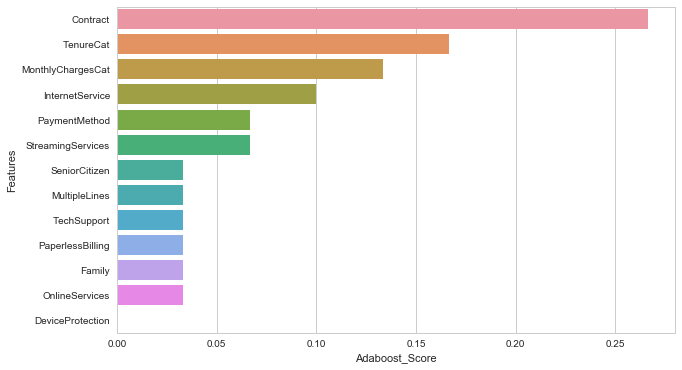

In [186]:
ab_cls = AdaBoostClassifier(learning_rate = 1.0, n_estimators = 30)

ab_cls.fit(X_train, Y_train)

feature_imp = np.round(ab_cls.feature_importances_, 5)
features = list(X_train.columns)
feature_imp_df = pd.DataFrame({'Features' :features, 'Adaboost_Score': feature_imp})
feature_imp_df.sort_values('Adaboost_Score', axis=0, ascending=False, inplace=True)
feature_imp_df

plt.figure(figsize=(10, 6))
sns.barplot( y = 'Features', x = 'Adaboost_Score', data = feature_imp_df )

# Observation:

- Overall - Contract, Monthly Charges, Tenure, Payment Method, Internet and streaming Service are leading columns contributing to churn.
- Device Protection has no impact on Churn

In [194]:
y_pred_test = ab_cls.predict(X_validation)
score_test = accuracy_score(Y_validation, y_pred_test)

CM = confusion_matrix( Y_validation , y_pred_test)
print( "Confusion Matrix: \n ",CM)

print ("TrueNegative:", CM[0][0])
print ("FalseNegative:", CM[1][0])
print ("TruePostive:", CM[1][1])
print ("FalsePostive:", CM[0][1])

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Sensitivity",TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specificity",TNR)
    
#Precision, Recall and F1 score
F1_score = f1_score(Y_validation, y_pred_test)
print("F1 Score: ", F1_score)
Precision_score = precision_score(Y_validation, y_pred_test)
print("Precision: ", Precision_score)
Recall_score = recall_score(Y_validation, y_pred_test)
print("Recall: ", Recall_score)
    
#Calculating average precision 
try:
    y_pred_score = ab_cls.decision_function(X_validation)
except:
    y_pred_score = ab_cls.predict_proba(X_validation)[:,1]

average_precision = average_precision_score(Y_validation, y_pred_score)
print("AUC: ", average_precision)

print( 'Total Accuracy : ',np.round( accuracy_score( Y_validation, y_pred_test ), 2 ) )

Confusion Matrix: 
  [[960  77]
 [182 190]]
TrueNegative: 960
FalseNegative: 182
TruePostive: 190
FalsePostive: 77
Sensitivity 0.510752688172043
Specificity 0.9257473481195757
F1 Score:  0.594679186228482
Precision:  0.7116104868913857
Recall:  0.510752688172043
AUC:  0.6741362489527705
Total Accuracy :  0.82
